In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.signal import tukey
from sklearn import ensemble
from sklearn.preprocessing import Imputer
import pandas as pd
import pylab

import MonashGWTools.tools as mgw_tools

from matplotlib import get_backend

In [3]:
WAVEFORM_PATH = "../Data/Strain/"
BNSStructure_Filename="../BNSStructure.csv"
TUKEY_FREQUENCY = 6e3
USE_TUKEY_WINDOW = True
OFFSET_WAVEFORMS = True
LABEL_NAMES = ["Kappa_calc", "MeanMass", "Mtov", "C", "EOS_rank", "J",
    "fcont", "MADM", "Mb", "MeanR", "Meank2", "MoI","q"]
ASDAdvLigoNoiseCurve='./MonashGWTools/NoiseCurves/aLIGO_ZERO_DET_high_P_asd.txt'
PSDAdvLigoNoiseCurve='./MonashGWTools/NoiseCurves/aLIGO_ZERO_DET_high_P_psd.txt'
Plots=True
Noisy=False
NoiseAmp=1


In [4]:

def ScaledMetric(deltat,h1,h2):
    '''
    metric = sqrt(<dh,dh>)
    where dh = h1 - h2
    '''
    # print('metric length={}'.format(len(h1)))
    Fs=1/deltat
    ligo_psd = np.loadtxt(PSDAdvLigoNoiseCurve)
    h1f,ff=mgw_tools.nfft(h1,Fs)
    h2f,ff=mgw_tools.nfft(h2,Fs)
    dh = h1f - h2f
    dhpow2 = mgw_tools.inner_product(dh,dh,ff,ligo_psd)
    return( np.sqrt(dhpow2) )

def SNR(deltat,horig):
    '''
    SNR = sqrt(<horig,horig>)
    '''
    # print('SNR length={}'.format(len(horig)))
    Fs=1/deltat
    ligo_psd = np.loadtxt(PSDAdvLigoNoiseCurve)
    hf,ff=mgw_tools.nfft(horig,Fs)
    snrval=np.sqrt(mgw_tools.inner_product(hf,hf,ff,ligo_psd))
    return(snrval)


def get_imag_offset_indices(X, K):
    indices = np.argmin(X[:, K:], axis=1)
    return indices - indices.min()

def get_real_offset_indices(X, K):
    indices = np.argmax(X[:, :K], axis=1)
    return indices - indices.min()


In [31]:


H = 2976
K = 1489 # Size of Hf.

rfr_kwds = dict(n_estimators=100, oob_score=True, verbose=False, criterion='mse',
    random_state=42) # , criterion="mse" default=gini

all_waveforms = Table.read(BNSStructure_Filename)
all_waveforms["match"] = [e.split("/")[-1].split(".")[0].strip() for e in all_waveforms["FullFilename"]]
unique_eos = sorted(list(set(all_waveforms["EOS"])))
all_waveforms["EOS_rank"] = [unique_eos.index(each) for each in all_waveforms["EOS"]]
all_waveforms=all_waveforms[all_waveforms['EOS']!='GAM2']

FontSize=10
PlotLabelFontSize=12
ReducedFontSize=8

textx=0.95 # position of plot labels in graph
texty=0.85 # ""  


# keep = (all_waveforms["EOS"] != "GAM2") * (all_waveforms["q"] == 1.0)
#all_waveforms = all_waveforms[keep]


all_waveforms.sort(LABEL_NAMES)

S = len(all_waveforms)
L = len(LABEL_NAMES)

hplus = np.zeros((S, H))
frequency = np.zeros(K)
Hfs = (0 + 0j) * np.ones((S, K))

for randomrun in range(100):
    if randomrun == 0:
        randomseed=42 # value used for default
    else: 
        randomseed = randomrun
    rfr_kwds = dict(n_estimators=100, criterion="mse", oob_score=True, verbose=False,
    random_state=randomseed,n_jobs=-1)
    

    chi_squared = np.zeros(S)
    Sqrtdhdh=np.zeros(S)
    SNRvals=np.zeros(S)
    ErrorRatio=np.zeros(S)
    waveform_name=np.zeros(S,dtype=object)

    min_recon_value = 1.0e-32
    
    for s, waveform in enumerate(all_waveforms):

        # Get the strain path.
        strain_path = os.path.join(WAVEFORM_PATH, "{}.csv".format(waveform["match"]))
        strain_timeseries = Table.read(strain_path)

        sampling_frequency = 1/np.mean(np.diff(strain_timeseries["time"]))

        if USE_TUKEY_WINDOW:
            rise_time = 0.35/TUKEY_FREQUENCY
            alpha = 2 * rise_time/(np.ptp(strain_timeseries["time"]))
            N = len(strain_timeseries)

            hplus[s] = (strain_timeseries["hplus"] * tukey(N, alpha=alpha))[:H]

        else:
            hplus[s] = strain_timeseries["hplus"][:H]

        if s==0:
            hp=hplus[s]
            wname=waveform["match"]
        Hfs[s], frequency = mgw_tools.nfft(hplus[s], sampling_frequency)

    X = np.hstack([np.real(Hfs), np.imag(Hfs)])

    # Offset the real/imaginary features.
    real_offsets = get_real_offset_indices(X, K)
    imag_offsets = get_imag_offset_indices(X, K)
    #print('real offsets={},imag offsets={}'.format(real_offsets,imag_offsets))

    # Pad zeros to the left.
    K_offset = K + real_offsets.max()
    X_offset = np.zeros((S, 2*K + real_offsets.max() + imag_offsets.max()))
    for i, (real_offset, imag_offset) in enumerate(zip(real_offsets, imag_offsets)):

        pad_real_zeros = real_offsets.max() - real_offset
        pad_imag_zeros = imag_offsets.max() - imag_offset

        # Pad with zeros or the left-most value.
        #X_offset[i, :pad_real_zeros] = np.ones(pad_real_zeros) * X[i, 0]
        #X_offset[i, K_offset:K_offset + pad_imag_zeros] = np.ones(pad_imag_zeros) * X[i, K]

        X_offset[i, pad_real_zeros:K + pad_real_zeros] = X[i, :K]
        X_offset[i, K_offset + pad_imag_zeros:K_offset + pad_imag_zeros + K] = X[i, K:]




#     if Plots:
#         fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
#         axes = np.array(axes).flatten()
#         for i in range(S):
#             axes[0].plot(X[i, :K], c='b', alpha=0.1)
#             axes[2].plot(X[i, K:], c='b', alpha=0.1)

#             axes[1].plot(X_offset[i, :K_offset], c='k', alpha=0.1)
#             axes[3].plot(X_offset[i, K_offset:], c='k', alpha=0.1)
#         plt.close('all')


    use_X = X_offset if OFFSET_WAVEFORMS else X
    use_K = K_offset if OFFSET_WAVEFORMS else K

    y = np.array([all_waveforms[ln] for ln in LABEL_NAMES]).T

    myimp=Imputer(strategy='median')
    y=myimp.fit_transform(y) # Replace NaN values with median column values so that the RF is unbiased

    """
    y = np.hstack([y, y**2])
    for i in range(S):
        for j in range(S):
            if i >= j: continue
            _ = (y[:, i] * y[:, j]).reshape((1, -1))
            y = np.hstack([y, _.T])
    """

    scalar = np.abs(use_X).max()

    # Train on real and imaginary parts.
    inverse_model = ensemble.RandomForestRegressor(**rfr_kwds)
    inverse_model.fit(y, use_X/scalar)

    reconstructed_real_imag = inverse_model.predict(y) * scalar


    chi_squared = np.zeros(S)
    Sqrtdhdh=np.zeros(S)
    SNRvals=np.zeros(S)
    ErrorRatio=np.zeros(S)

    original_reconstructed_hplus = []
    freqindexmask=(frequency>100) & (frequency<6000)
    # Plots: real, imag, timeseries.
    for i in range(S):
        real, imag = (reconstructed_real_imag[i, :use_K], reconstructed_real_imag[i, use_K:])
        if OFFSET_WAVEFORMS:

            pad_real_zeros = real_offsets.max() - real_offsets[i]
            pad_imag_zeros = imag_offsets.max() - imag_offsets[i]

            real_ = np.zeros(K, dtype=float)
            imag_ = np.zeros_like(real_)

            real_ = real[pad_real_zeros:K + pad_real_zeros]
            imag_ = imag[pad_imag_zeros:K + pad_imag_zeros]

            # axes[0].plot(real_, c='b')
            # axes[0].plot(X[i, :K], c='#666666')
            #
            # axes[1].plot(imag_, c='b')
            # axes[1].plot(X[i, K:], c='#666666')

            real, imag = (real_, imag_)

        reconstructed_Hfs = real + 1j * imag
        reconstructed_hplus = mgw_tools.infft(reconstructed_Hfs,sampling_frequency)
        # HACK
        chi_squared[i] = np.sum((reconstructed_hplus - hplus[i])**2)
        # Adv LIGO noise referenced metrics
        DeltaT=np.mean(np.diff(strain_timeseries["time"]))
        Sqrtdhdh[i] = ScaledMetric(DeltaT,reconstructed_hplus,hplus[i]) # this is only half the time samples
        SNRvals[i]=SNR(DeltaT,hplus[i])
        ErrorRatio[i]=Sqrtdhdh[i] / SNRvals[i]
    print( "\nrandom seed={}, min/max Sqrtdhdh=({:.2f},{:.2f})".format(
                randomseed,min(Sqrtdhdh),max(Sqrtdhdh)))
    if randomrun==0:
        SNRresidarray=Sqrtdhdh
    else:
        SNRresidarray=np.vstack([SNRresidarray,Sqrtdhdh])
residuals = pd.DataFrame(SNRresidarray)

# duration = 1  # second
# freq = 440  # Hz
# os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))



random seed=42, min/max Sqrtdhdh=(0.47,1.49)

random seed=1, min/max Sqrtdhdh=(0.55,1.42)

random seed=2, min/max Sqrtdhdh=(0.44,1.75)

random seed=3, min/max Sqrtdhdh=(0.57,1.54)

random seed=4, min/max Sqrtdhdh=(0.60,1.44)

random seed=5, min/max Sqrtdhdh=(0.54,1.64)

random seed=6, min/max Sqrtdhdh=(0.55,1.44)

random seed=7, min/max Sqrtdhdh=(0.47,1.84)

random seed=8, min/max Sqrtdhdh=(0.53,1.50)

random seed=9, min/max Sqrtdhdh=(0.53,1.55)

random seed=10, min/max Sqrtdhdh=(0.62,1.58)

random seed=11, min/max Sqrtdhdh=(0.67,1.64)

random seed=12, min/max Sqrtdhdh=(0.57,1.84)

random seed=13, min/max Sqrtdhdh=(0.51,1.60)

random seed=14, min/max Sqrtdhdh=(0.62,1.57)

random seed=15, min/max Sqrtdhdh=(0.52,1.61)

random seed=16, min/max Sqrtdhdh=(0.56,1.60)

random seed=17, min/max Sqrtdhdh=(0.59,1.63)

random seed=18, min/max Sqrtdhdh=(0.46,1.62)

random seed=19, min/max Sqrtdhdh=(0.52,1.86)

random seed=20, min/max Sqrtdhdh=(0.63,1.63)

random seed=21, min/max Sqrtdhdh=(0.54,1.6

Written RFRRandomseed


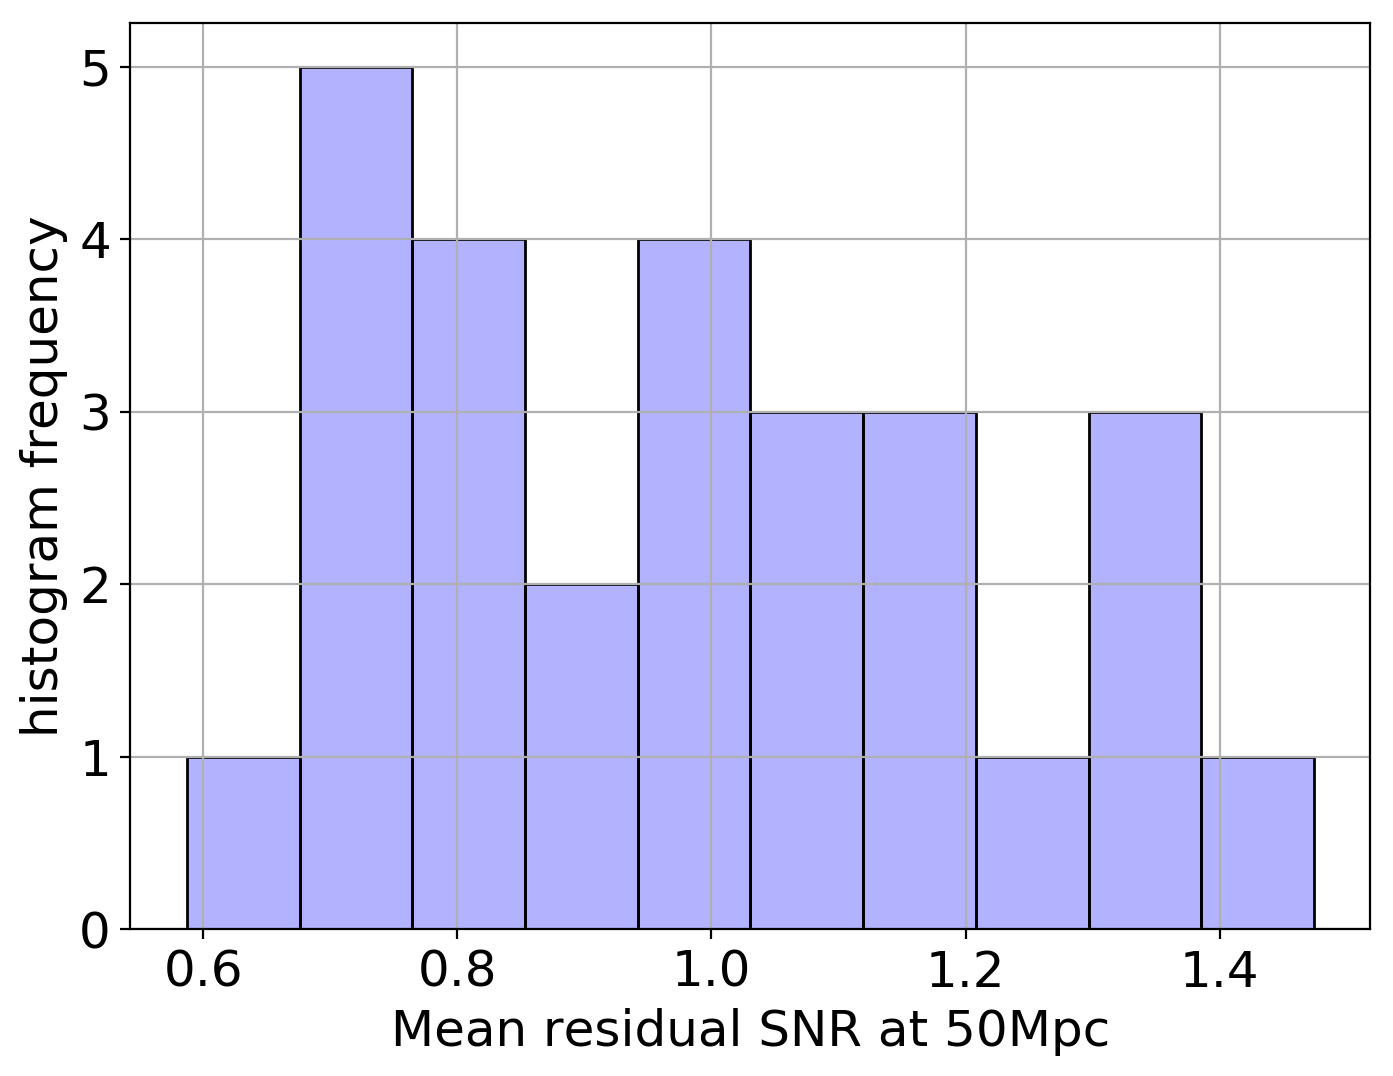

In [32]:
from matplotlib import rcParams

FontSize=18
rcParams.update({'font.size': FontSize})

plt.close('all')
# mybins=np.arange(0.1,2.1,0.2)
plt.figure(figsize=(8, 6), dpi=200)

residuals.mean(axis='rows').plot.hist(edgecolor='k',linewidth=1.0,fc=(0, 0, 1, 0.3))
plt.grid(which='major',axis='both')
ax = plt.gca()
# ax.set_xticks(mybins[:-1]+0.1)
#plt.title('RFR-Real/Imaginary')
plt.xlabel('Mean residual SNR at 50Mpc',fontsize=FontSize)
plt.ylabel('histogram frequency',fontsize=FontSize)

filename='RFRRandomseed'
shortcaption='Mean histogram for the residual SNR of the random forest regression for 20 random values.'
caption=r"""Mean histogram of the residual SNR for the random forest regression algorithm without 
    cross-validation. There were a total of 100 different random seeds used to generate this plot.
    % RFRRandomseed.ipynb"""

plt.savefig('{}.pdf'.format(filename))
text_file = open('{}.txt'.format(filename), "w")
text_file.write(caption)
text_file.close()
text_file = open('{}Short.txt'.format(filename), "w")
text_file.write(shortcaption)
text_file.close()

print('Written {}'.format(filename))
plt.show()
        
# duration = 1  # second
# freq = 440  # Hz
# os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))


Written RFRresidualBoxEOSsorted


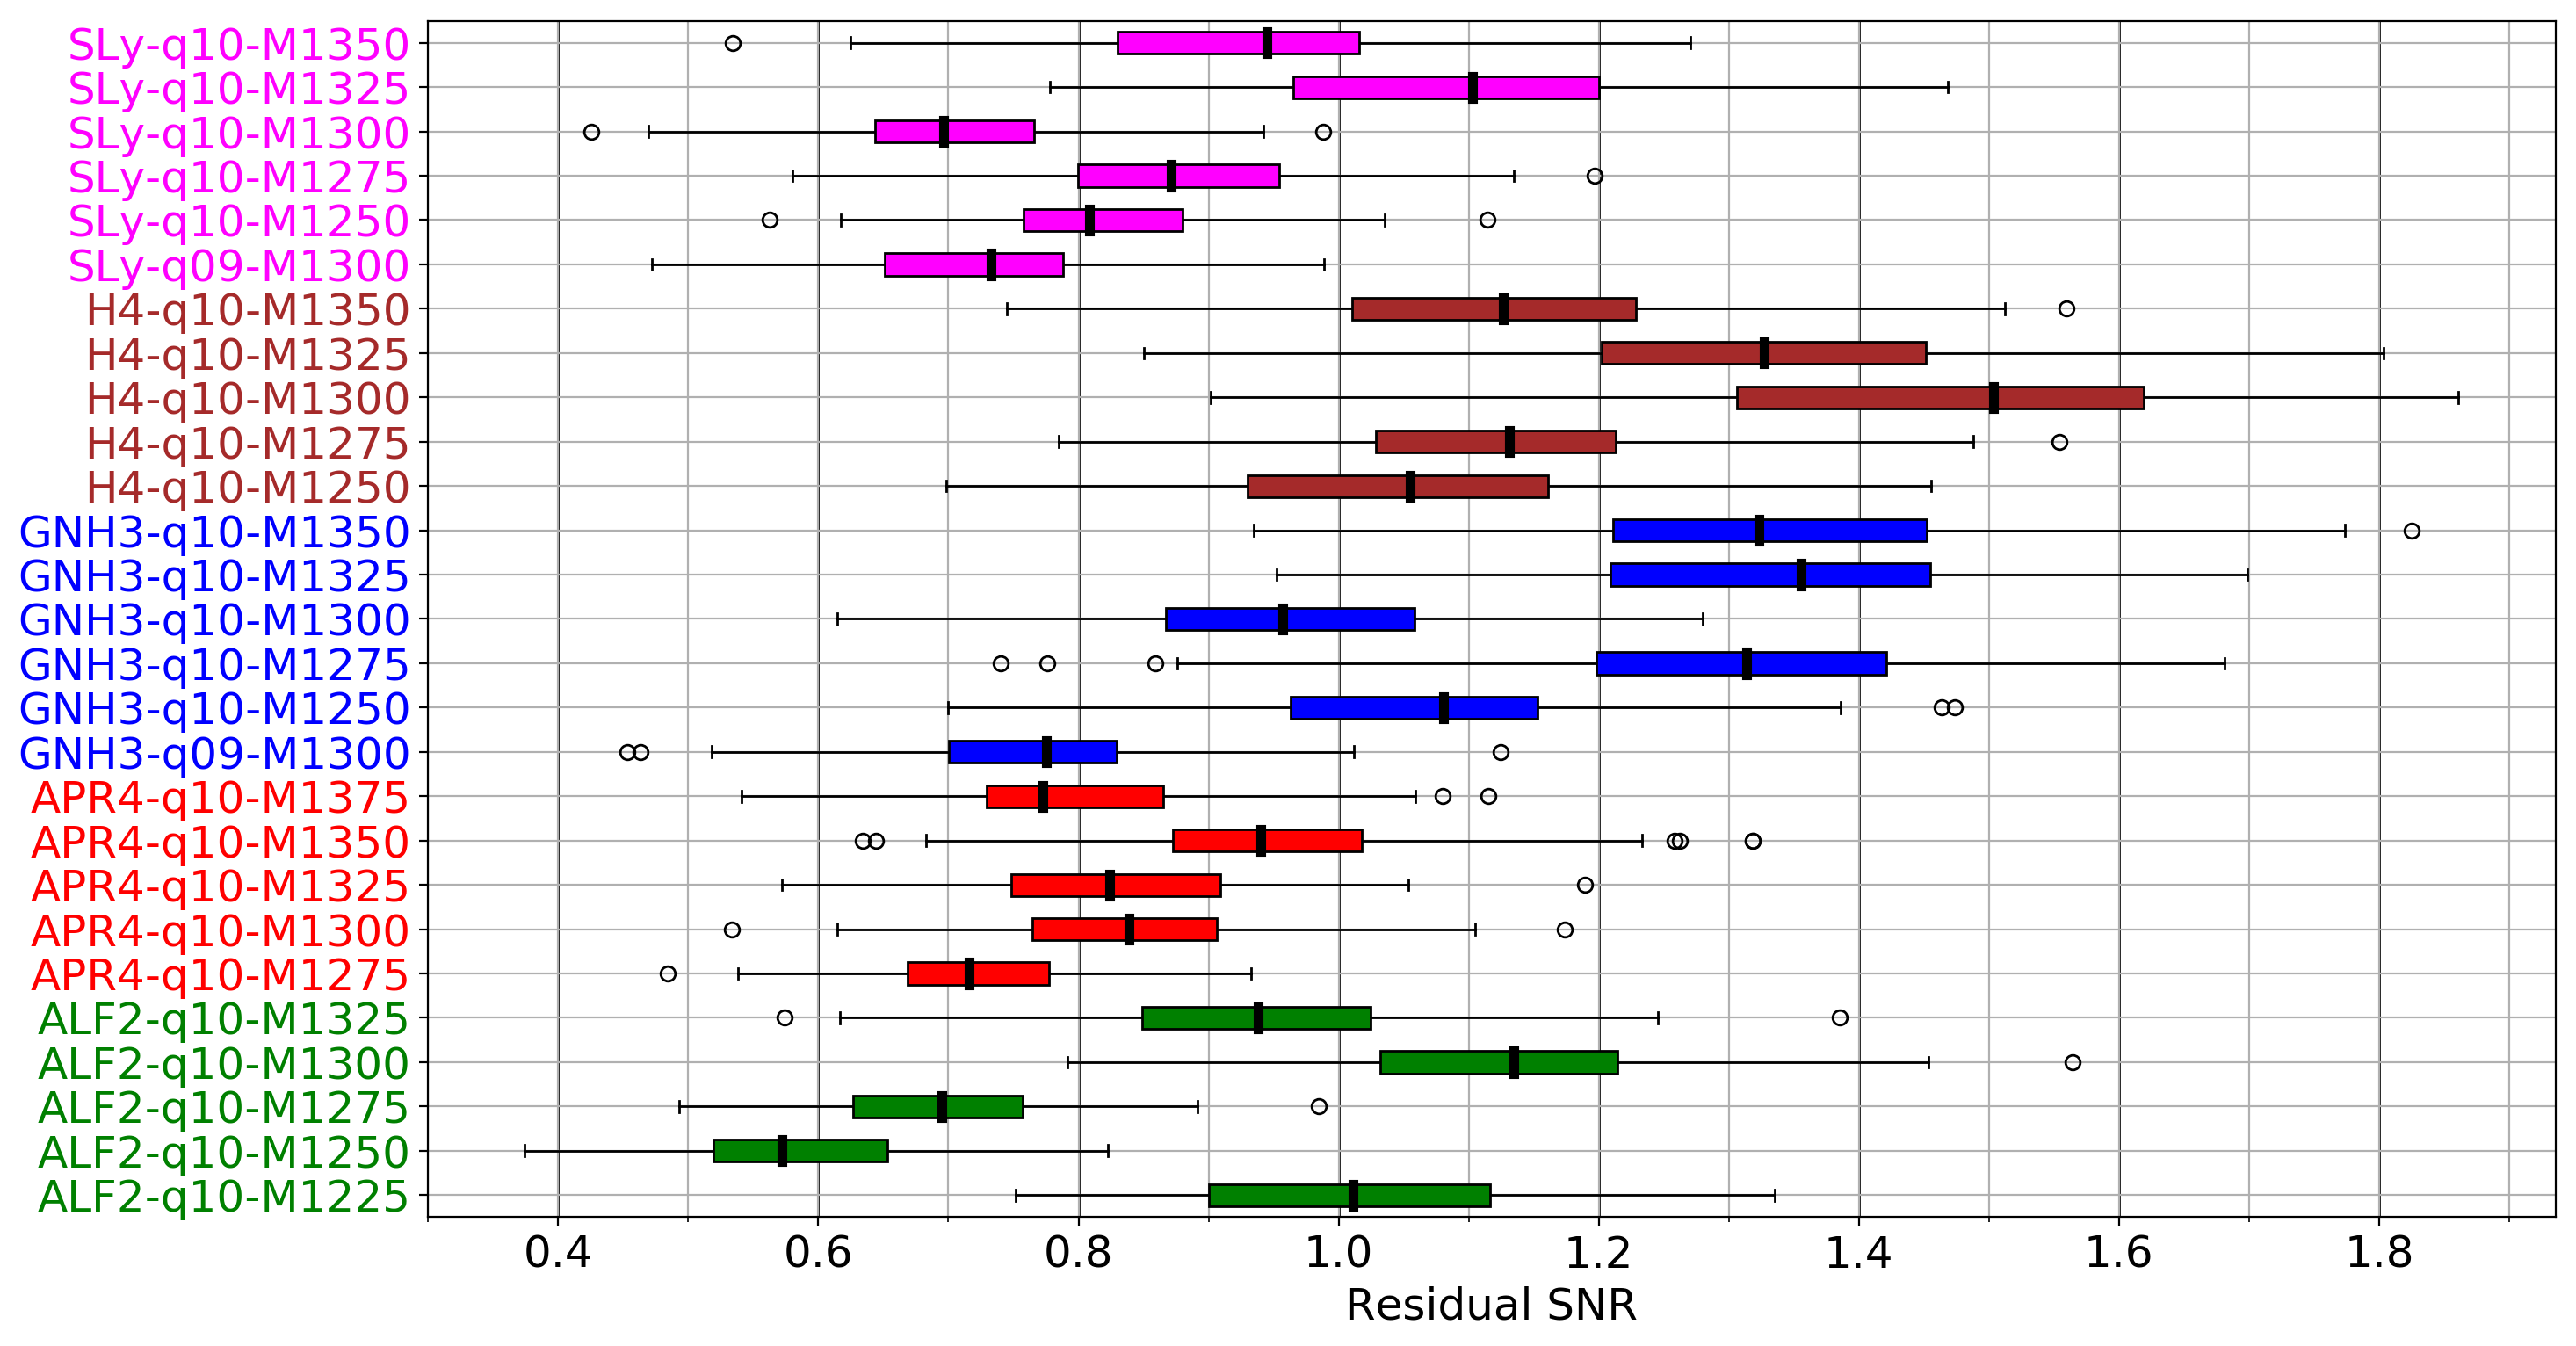

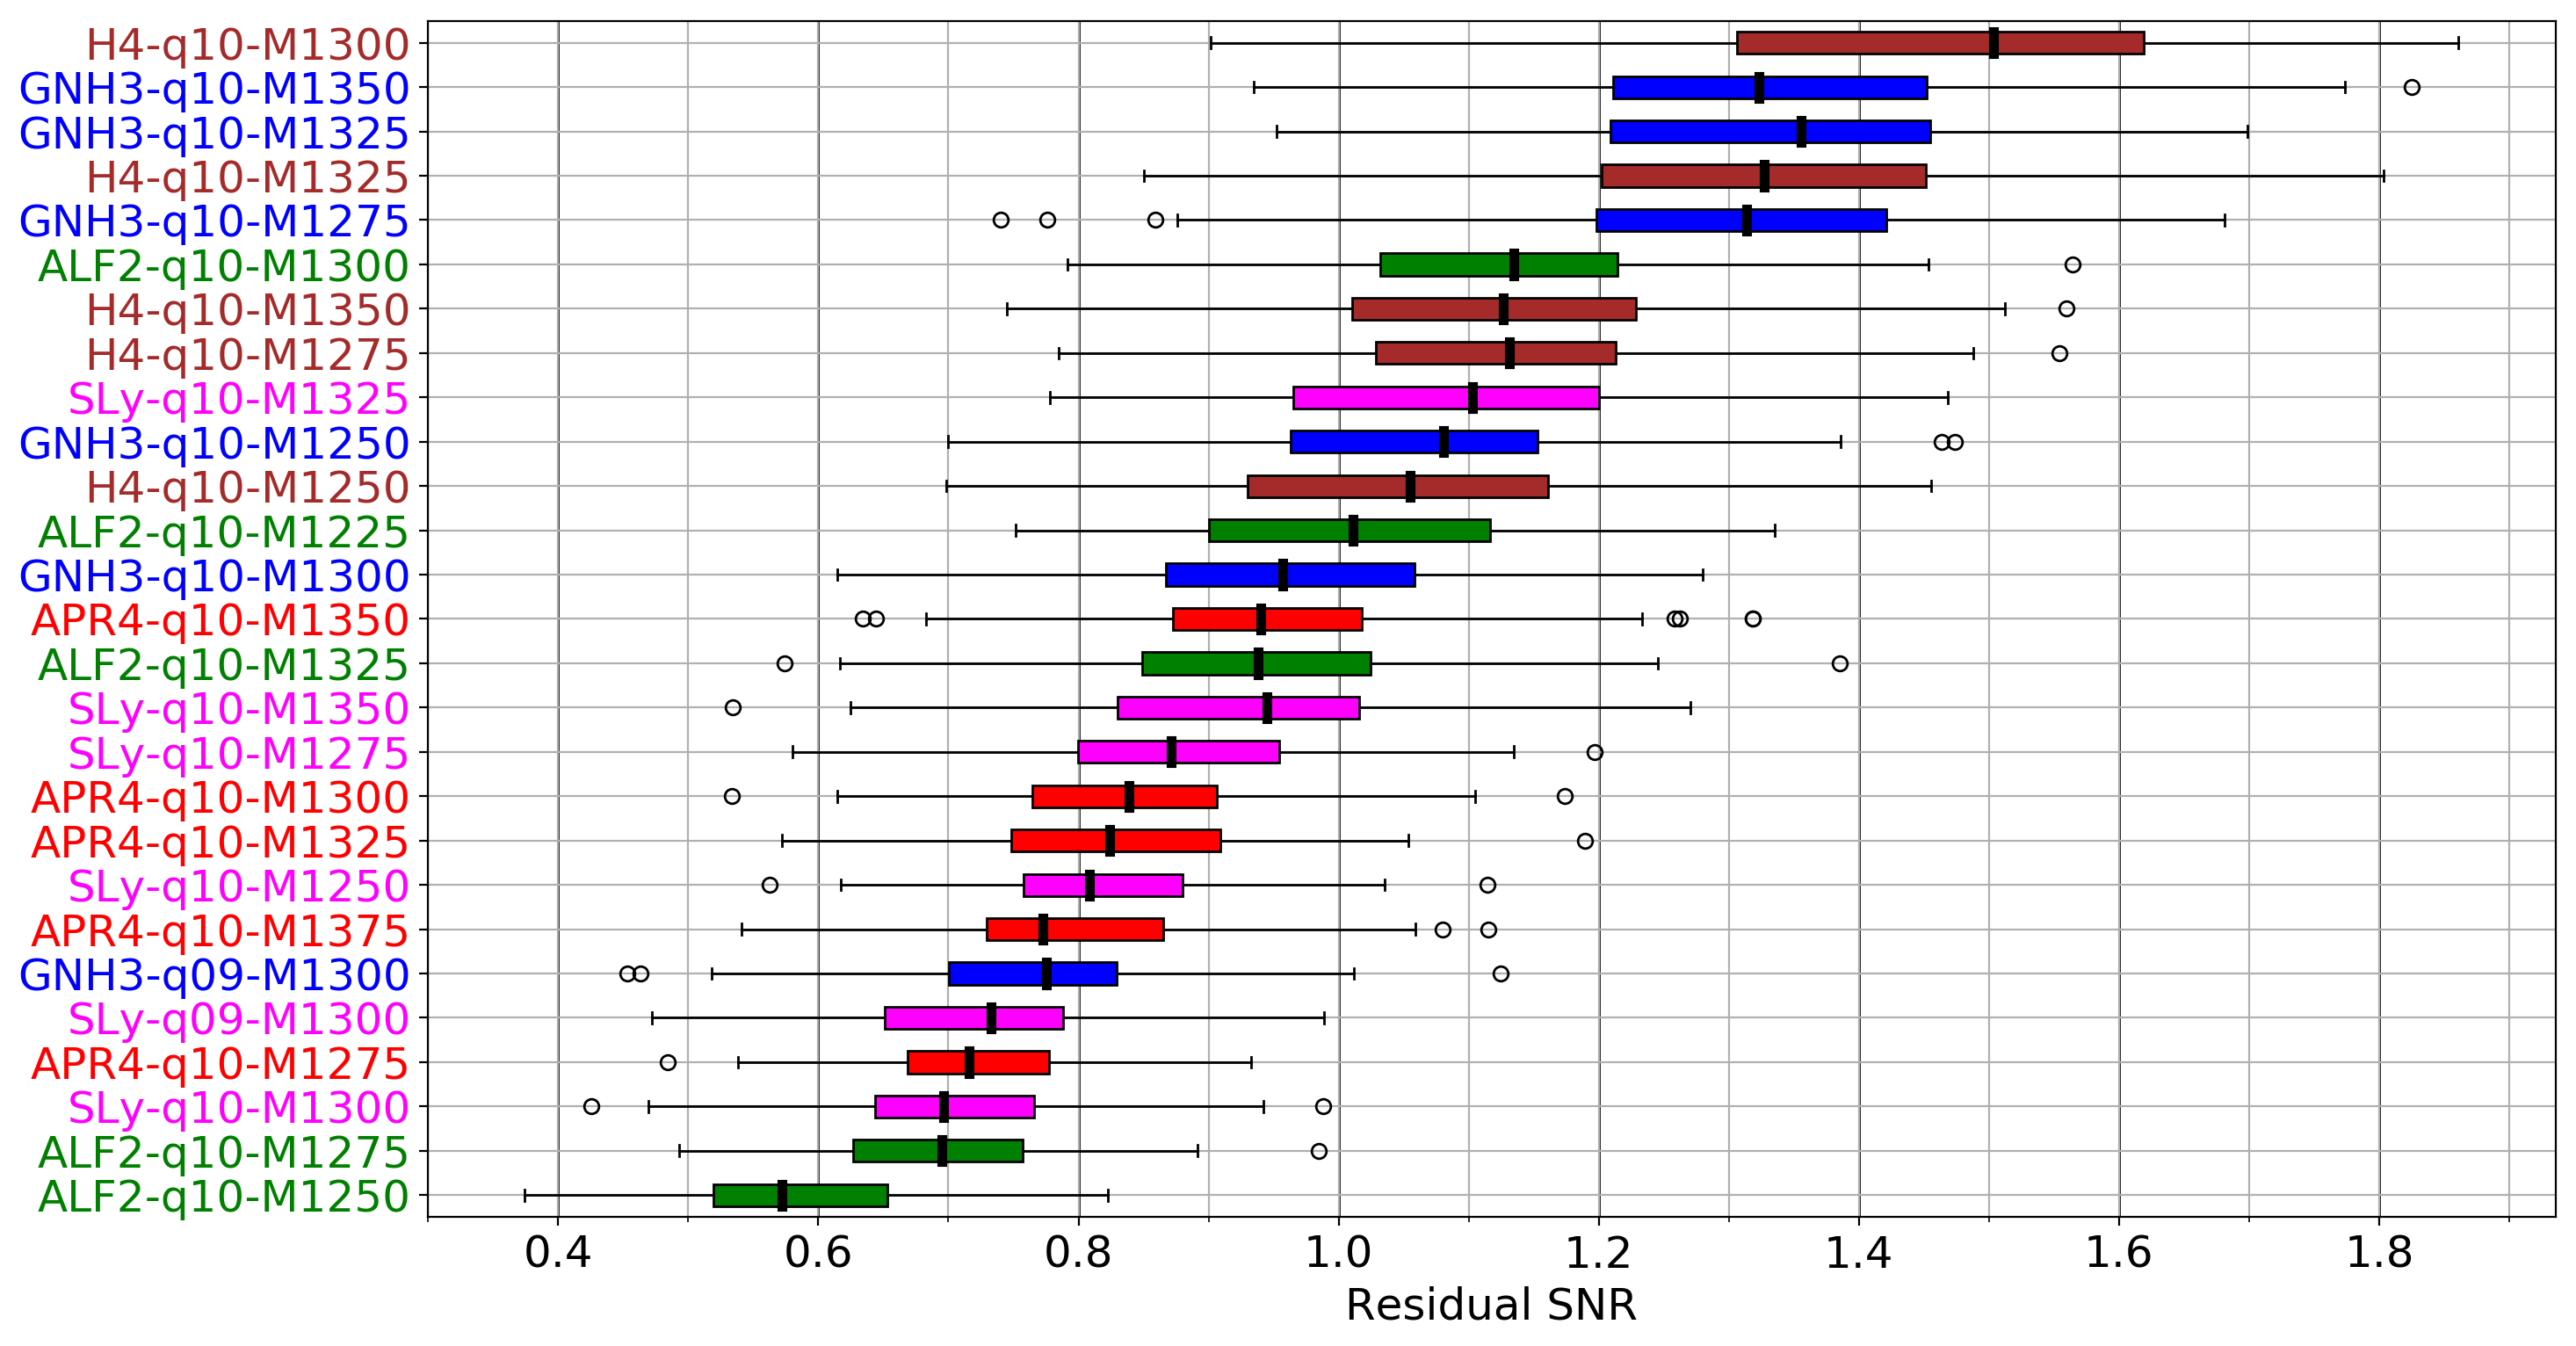

Written RFRresidualBoxMeansorted


In [33]:
# this plots the box plots for the residual SNR of the above data
# run the previous cell first

from matplotlib.ticker import MultipleLocator

BoxLabelFontSize=18
#get the colours for the respective EOS/mass combos
medianprops = dict( linewidth=4.0, color='k')
# boxprops=dict(linestyle='-',linewidth=4.0,color='k')
# flierprops=dict(linestyle='-',linewidth=4.0,color='k')




colorvalues={'GNH3':'blue','H4':'brown','ALF2':'green','SLy':'magenta','APR4':'red'}
all_waveforms['colour']=[colorvalues[name.split('-')[0]] for name in all_waveforms['match']]
sss=all_waveforms[['match','colour']]
data={'match':np.array(sss['match']),'colour':np.array(sss['colour'])}
sss=pd.DataFrame(data=data)
sss=sss.set_index('match')
qqq=pd.DataFrame(data=SNRresidarray,columns=all_waveforms['match'])
qqq.loc[-1]=sss['colour']
qqq.index=qqq.index+1
qqq=qqq.sort_index()
qqq=qqq.reindex_axis(sorted(qqq.columns), axis=1) # sort by waveform name

plt.close('all')
plt.figure(figsize=(15,8),dpi=200)
ax=plt.gca()
boxdata=qqq.loc[1:].as_matrix().astype(np.float)
boxlabels=qqq.columns
boxcolours=qqq.loc[0]
bplot=ax.boxplot(boxdata,
                vert=False,
                patch_artist=True,
                labels=boxlabels,
                notch=False,
                medianprops=medianprops)
for patch,colour in zip(bplot['boxes'],boxcolours):
    patch.set_facecolor(colour)
[tl.set_color(i) for (i,tl) in
 zip(boxcolours,ax.yaxis.get_ticklabels())]    
#qqq.loc[1:].plot.box(color=qqq.loc[0])
plt.xticks(fontsize=BoxLabelFontSize)
ml = MultipleLocator(0.1)
ax.xaxis.set_minor_locator(ml)
plt.yticks(fontsize=BoxLabelFontSize)
ax.xaxis.grid(which='minor')
ax.xaxis.grid(which='major',color='k',linestyle='-',linewidth=1)
ax.yaxis.grid(which='major')
plt.xlabel('Residual SNR',fontsize=BoxLabelFontSize)
# plt.show()
filename='RFRresidualBoxEOSsorted'
shortcaption='Box plot of the random forest residual SNR for 100 random values sorted by EOS and mass.'
caption=r"""Box plot of the residual SNR for each waveform using random forest regression without cross-validation. 
    The plots
    have been sorted by equation of state and mass combinations. The coloured box
    indicates the interquartile range, the thick vertical black line indicates the median value. The thin 
    horizontal lines pass from the minimum value to the maximum values, excluding outliers. The outliers are
    indicated as round circles on the plot. % RFRRandomseed.ipynb"""
plt.tight_layout()
plt.savefig('{}.pdf'.format(filename))
text_file = open('{}.txt'.format(filename), "w")
text_file.write(caption)
text_file.close()
text_file = open('{}Short.txt'.format(filename), "w")
text_file.write(shortcaption)
text_file.close()

print('Written {}'.format(filename))

qqqq=qqq.reindex_axis(qqq.loc[1:].mean().sort_values().index, axis=1) # sort by mean value of residual SNR


plt.figure(figsize=(15,8),dpi=200)
ax=plt.gca()
boxdata=qqqq.loc[1:].as_matrix().astype(np.float)
boxlabels=qqqq.columns
boxcolours=qqqq.loc[0]
bplot=ax.boxplot(boxdata,
                vert=False,
                patch_artist=True,
                labels=boxlabels,
                notch=False,
                medianprops=medianprops)
for patch,colour in zip(bplot['boxes'],boxcolours):
    patch.set_facecolor(colour)
[tl.set_color(i) for (i,tl) in
 zip(boxcolours,ax.yaxis.get_ticklabels())] 
# qqqq.loc[1:].plot.box()
plt.yticks(fontsize=BoxLabelFontSize) # rotation='vertical',
ax.xaxis.set_minor_locator(ml)
plt.xticks(fontsize=BoxLabelFontSize)
ax.xaxis.grid(which='minor')
ax.xaxis.grid(which='major',color='k',linestyle='-',linewidth=1)
ax.yaxis.grid(which='major')
plt.xlabel('Residual SNR',fontsize=BoxLabelFontSize)
filename='RFRresidualBoxMeansorted'
shortcaption='Box plot of the random forest residual SNR for 100 random values sorted by mean residual SNR.'
caption=r"""Box plot of the residual SNR for each waveform using random forest regression without 
    cross-validation. The plots have been sorted by the mean value of the residual SNR. The coloured box
    indicates the interquartile range, the thick vertical black line indicates the median value. The thin 
    horizontal lines pass from the minimum value to the maximum values, excluding outliers. The outliers are
    indicated as round circles on the plot.
    % RFRRandomseed.ipynb"""
plt.tight_layout()
plt.savefig('{}.pdf'.format(filename))
text_file = open('{}.txt'.format(filename), "w")
text_file.write(caption)
text_file.close()
text_file = open('{}Short.txt'.format(filename), "w")
text_file.write(shortcaption)
text_file.close()
plt.show()
print('Written {}'.format(filename))

In [18]:
keep=all_waveforms['EOS']!='GAM2'
x=all_waveforms[keep]
x['EOS']=='GAM2'

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False], dtype=bool)

In [ ]:
all_waveforms.shape

Written RFRReImHist


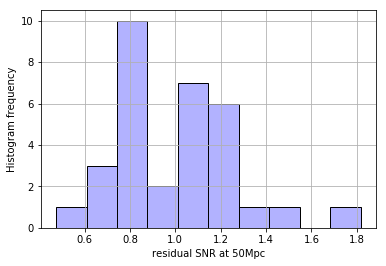

In [25]:


plt.close('all')
# mybins=np.arange(0.1,2.1,0.2)
MetricValues['SNRresidual'].plot.hist(edgecolor='k',linewidth=1.0,fc=(0, 0, 1, 0.3)) # bins=mybins,
plt.grid(which='major',axis='both')
ax = plt.gca()
# ax.set_xticks(mybins[:-1]+0.1)
#plt.title('RFR-Real/Imaginary')
plt.xlabel('residual SNR at 50Mpc')
plt.ylabel('Histogram frequency')
xlim= ax.get_xlim()
# MetricValues['SNRresidual_dup'].plot.hist(bins=mybins,edgecolor='k',linewidth=1.0,fc=(1, 0, 0, 0.3))
# plt.grid(which='major',axis='both')
# ax = plt.gca()
# plt.title('RFR-Real/Imaginary with duplication')
# plt.xlabel('residual SNR @ 50Mpc')
# ax.set_xticks(mybins[:-1]+0.1)
# ax.set_xlim(xlim)


filename='RFRReImHist'
shortcaption='Histogram for the residual SNR of the random forest regression.'
caption=r"""Histogram of the residual SNR for the random forest regression algorithm without
    cross-validation. % rfr_pe.ipynb"""

plt.savefig('{}.pdf'.format(filename))
text_file = open('{}.txt'.format(filename), "w")
text_file.write(caption)
text_file.close()
text_file = open('{}Short.txt'.format(filename), "w")
text_file.write(shortcaption)
text_file.close()

print('Written {}'.format(filename))
plt.show()

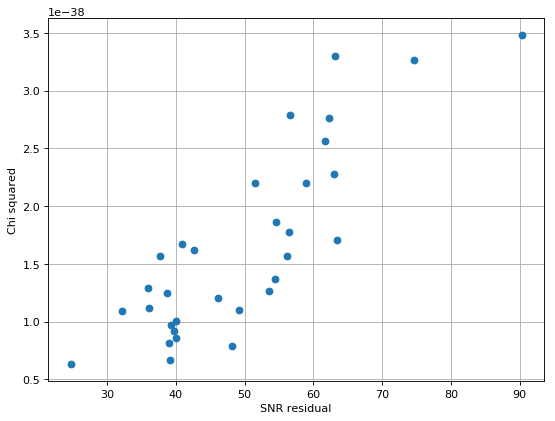

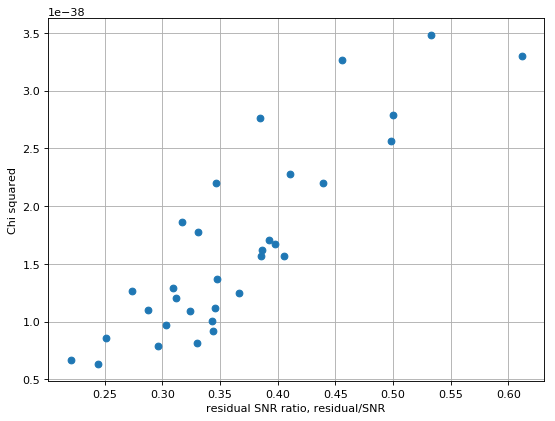

In [230]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(all_waveforms['SNRresidual'],all_waveforms['chi_sq'],linestyle='',marker='o')
plt.xlabel('SNR residual')
plt.ylabel('Chi squared')
plt.grid(which='major',axis='both')
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(all_waveforms['SNRresidual']/all_waveforms['SNR'],all_waveforms['chi_sq'],linestyle='',marker='o')
plt.xlabel('residual SNR ratio, residual/SNR')
plt.ylabel('Chi squared')
plt.grid(which='major',axis='both')
plt.show()

In [151]:
hpluswaveformnumber=4
all_waveforms[all_waveforms[0][:]==hpluswaveformnumber]


col0,C,EOS,Extension,FullFilename,J,Kappa_calc,M1,M2,MADM,Mb,MeanMass,MeanR,Meank2,MoI,Mtotal,Mtov,QINT,Rtov,dimTideDef,fcont,filename,forb,path,q,FreqSelect,fmax,FS,match,EOS_rank,chi_sq,SNR,SNRresidual
int64,float64,str4,str3,str73,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str14,float64,str29,float64,int64,float64,float64,str14,int64,float64,float64,float64
4,0.17344,APR4,dat,../GW_Catalog_Takami2014/data/APR4-q10-M1300.h_l2_m2.r500.t-1500_5000.dat,6.8245,75.9790490469,1.3,1.3,2.5763,1.4399,1.3,11.067,0.095396,12.436,2.6,2.2,10,9873.3,405.19,1795.5,APR4-q10-M1300,277.24,../GW_Catalog_Takami2014/data,1.0,2600,3126.78715683,120848.29323,APR4-q10-M1300,1,9.63055994315e-39,99.6484411126,30.754928452


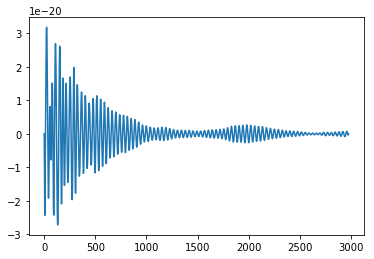

'APR4-q10-M1375'

In [140]:
plt.plot(hplus[0,:])
plt.show()
testH=hplus[0,:]
wname

In [141]:

SNR(DeltaT,testH)

92.866697959607748

In [29]:
1/DeltaT

120848.29323036097

In [138]:
ScaledMetric(DeltaT,hplus[0,:],hp)

0.0

In [50]:
p=[0.01*x for x in range(101)]

In [51]:
err=[ScaledMetric(DeltaT,testH,testH*(1-x))/SNRref for x in p]

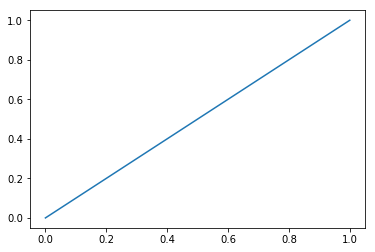

In [52]:
plt.plot(p,err)
plt.show()

In [62]:
q=np.array([[3,4],[1,7]])
qsh=q.shape
q.flatten()

array([3, 4, 1, 7])

In [59]:
q


array([[3, 4],
       [1, 7]])

In [76]:
q*(1+(np.random.random(q.shape)*2-1)*0.1)

array([[ 3.19026669,  4.32322586],
       [ 1.08511531,  6.77090568]])

In [77]:
qsh

(2, 2)

In [152]:
inverse_model.feature_importances_

array([ 0.0747881 ,  0.05816528,  0.01975168,  0.06896049,  0.03424678,
        0.12493752,  0.07022097,  0.05254632,  0.08426873,  0.15699713,
        0.18940425,  0.05654755,  0.00916522])

In [154]:
LABEL_NAMES

['Kappa_calc',
 'MeanMass',
 'Mtov',
 'C',
 'EOS_rank',
 'J',
 'fcont',
 'MADM',
 'Mb',
 'MeanR',
 'Meank2',
 'MoI',
 'q']

In [200]:
Importance=Table(names=LABEL_NAMES,data=inverse_model.feature_importances_).to_pandas()
Importance[Importance[Importance.ix[-Importance.last_valid_index()].argsort()].columns[::-1]]


,Meank2,MeanR,J,Mb,Kappa_calc,fcont,C,MeanMass,MoI,MADM,EOS_rank,Mtov,q
0,0.189404,0.156997,0.124938,0.084269,0.074788,0.070221,0.06896,0.058165,0.056548,0.052546,0.034247,0.019752,0.009165


In [231]:
Importance=Table(names=LABEL_NAMES,data=inverse_model.feature_importances_).to_pandas()
Importance[Importance[Importance.ix[-Importance.last_valid_index()].argsort()].columns[::-1]]

,Meank2,MeanR,J,Mb,Kappa_calc,fcont,MoI,MADM,C,MeanMass,EOS_rank,Mtov,q
0,0.164135,0.162388,0.129207,0.091287,0.07992,0.076259,0.06519,0.060713,0.05428,0.051469,0.033642,0.024346,0.007164


In [218]:
print('before={}'.format(np.isnan(y).any()))
from sklearn.preprocessing import Imputer
myimp=Imputer(strategy='median')
newy=myimp.fit_transform(y)
print('after={}'.format(np.isnan(newy).any()))

before=True
after=False


In [221]:
nanindices=np.argwhere(np.isnan(y))
nanindices


array([[30,  0],
       [31,  0]])

In [226]:
y[30,0],newy[30,0],y[31,0],newy[31,0]

(nan, 213.07278305835001, nan, 213.07278305835001)

In [180]:
new_columns = Importance.columns[Importance.ix+[Importance.last_valid_index()].np.argsort()]

0.0747880988407


In [181]:
qq=qqq[0]

In [183]:
type(qq)

astropy.table.table.Table

/home/paule/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


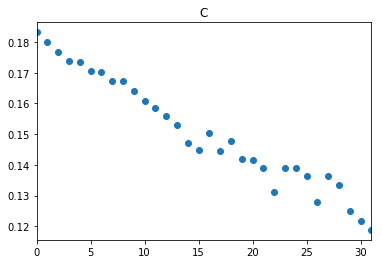

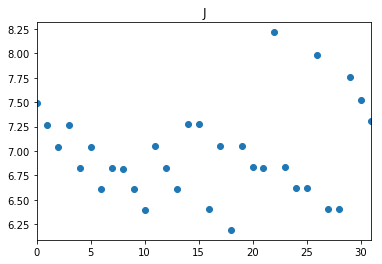

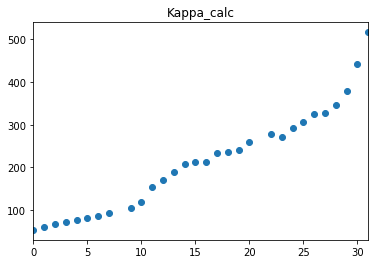

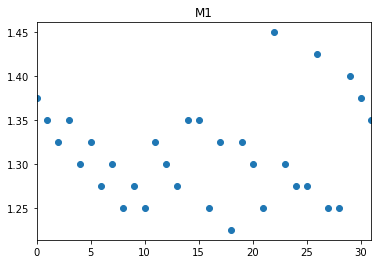

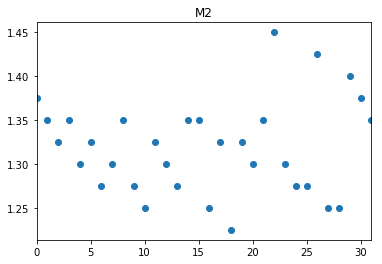

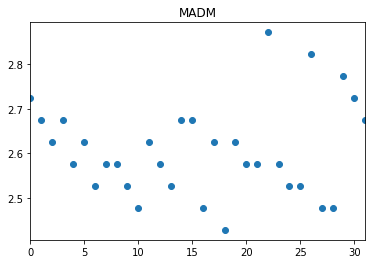

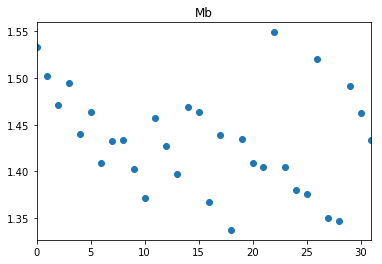

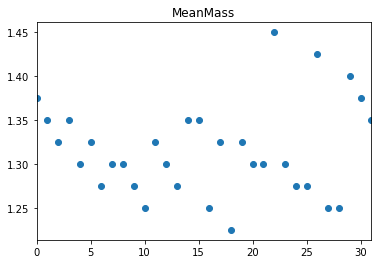

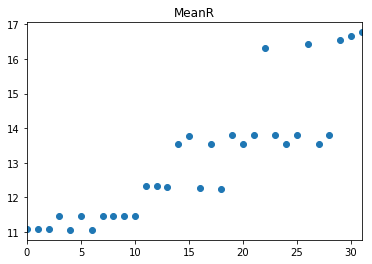

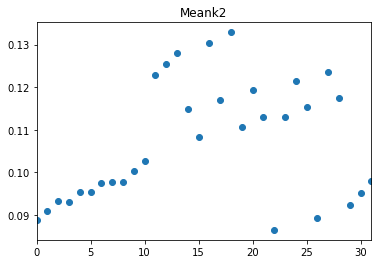

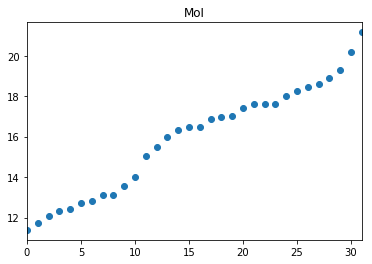

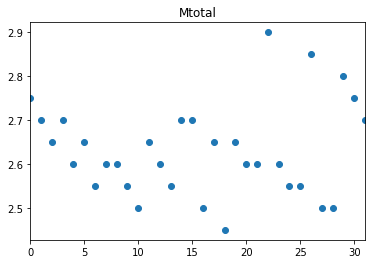

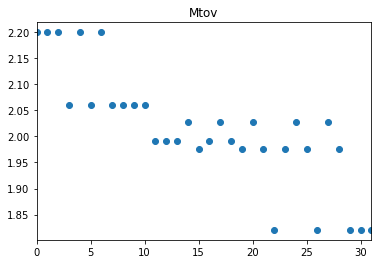

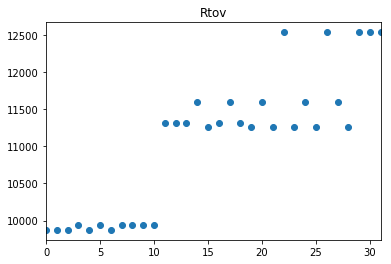

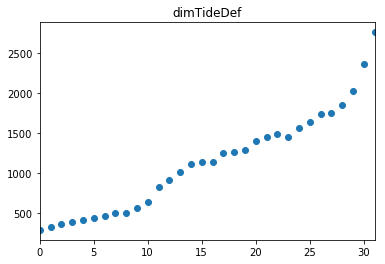

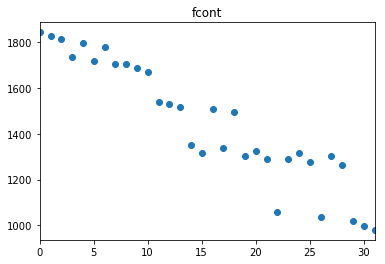

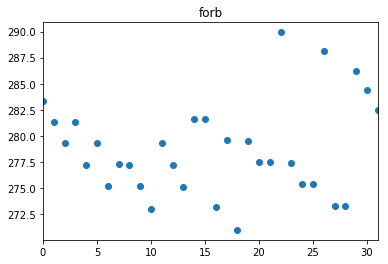

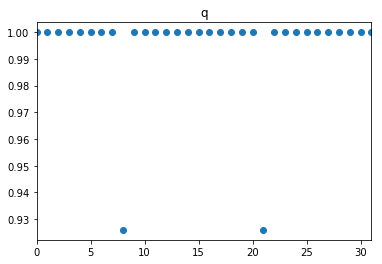

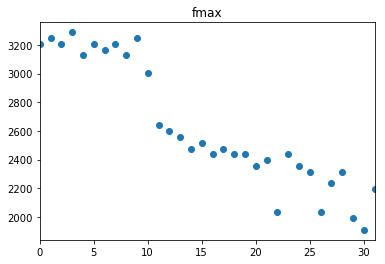

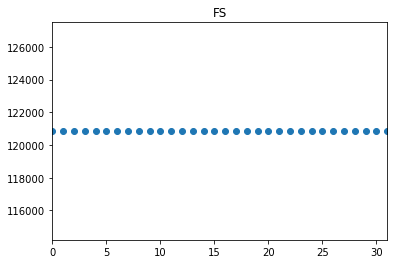

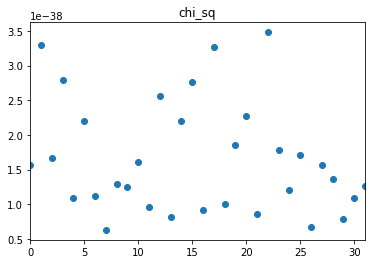

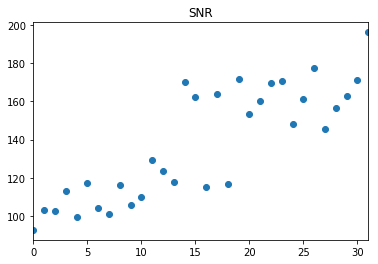

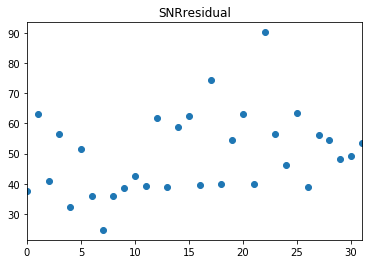

In [255]:
df=all_waveforms.to_pandas()
df=df.sort_values(['MoI','Meank2','MeanR'])
df=df.reset_index(drop=True)
for col in df:
    if df[col].dtypes == 'float64':
        plt.figure()
        df[col].plot(linestyle='',marker='o')
        plt.title(col)
plt.show()

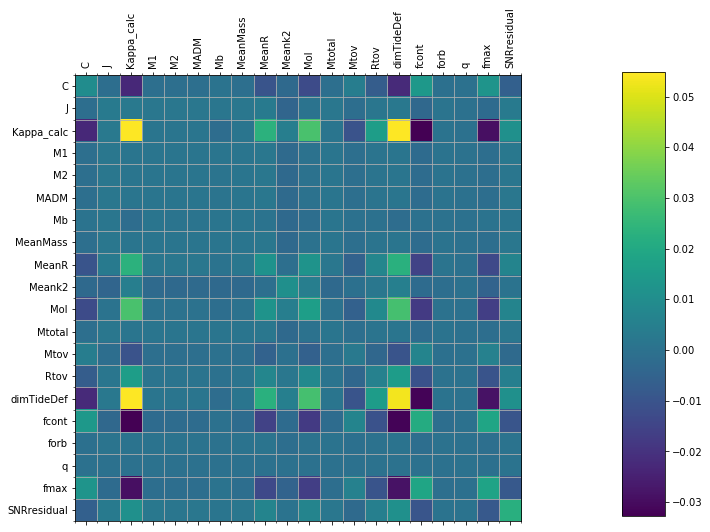

In [333]:
pylab.rcParams['figure.figsize']=(10.0,8.0)
dff=all_waveforms.to_pandas().select_dtypes(include=['float64']).drop(['SNR','FS','chi_sq'],axis=1)
all_waveforms['match']
dff=dff.divide(dff.max())#
dff=dff.reset_index(drop=True)
dfff=dff.cov()
plt.figure(num=1, figsize=(15.0, 12.0), dpi=200, facecolor='w', edgecolor='k')
plt.matshow(dfff,label=dfff.columns)
plt.grid(which='major',axis='both',alpha=0.0)
plt.grid(which='minor',axis='both',alpha=1.0)
minor_ticks=np.arange(-0.5,len(ticklabels)+0.5,1)
ticklabels=all_waveforms.to_pandas().select_dtypes(include=['float64']).drop(['SNR','FS','chi_sq'],axis=1).columns
plt.xticks(list(range(len(ticklabels))),ticklabels,rotation='vertical')
plt.yticks(list(range(len(ticklabels))),ticklabels,rotation='horizontal')
ax=plt.gca()
#ax.set_xticklabels(ticklabels)
ax.set_xticks(minor_ticks, minor=True) 
ax.set_yticks(minor_ticks, minor=True) 
cax = plt.axes([1.1, 0.1, 0.075, 0.77])
plt.colorbar(cax=cax)

plt.show()

In [286]:
df.columns



Index(['col0', 'C', 'EOS', 'Extension', 'FullFilename', 'J', 'Kappa_calc',
       'M1', 'M2', 'MADM', 'Mb', 'MeanMass', 'MeanR', 'Meank2', 'MoI',
       'Mtotal', 'Mtov', 'QINT', 'Rtov', 'dimTideDef', 'fcont', 'filename',
       'forb', 'path', 'q', 'FreqSelect', 'fmax', 'FS', 'match', 'EOS_rank',
       'chi_sq', 'SNR', 'SNRresidual'],
      dtype='object')

In [312]:
all_waveforms.to_pandas().select_dtypes(include=['float64']).drop(['SNR','FS','chi_sq'],axis=1).columns

Index(['C', 'J', 'Kappa_calc', 'M1', 'M2', 'MADM', 'Mb', 'MeanMass', 'MeanR',
       'Meank2', 'MoI', 'Mtotal', 'Mtov', 'Rtov', 'dimTideDef', 'fcont',
       'forb', 'q', 'fmax', 'SNRresidual'],
      dtype='object')

In [310]:
all_waveforms.to_pandas()['match']

0      SLy-q10-M1300
1     APR4-q10-M1300
2      SLy-q09-M1300
3     APR4-q10-M1275
4     APR4-q10-M1375
5      SLy-q10-M1275
6     ALF2-q10-M1275
7     GAM2-q10-M1425
8     ALF2-q10-M1325
9     ALF2-q10-M1250
10    GNH3-q09-M1300
11    ALF2-q10-M1225
12    APR4-q10-M1325
13     SLy-q10-M1250
14      H4-q10-M1275
15    GAM2-q10-M1400
16    GAM2-q10-M1375
17     SLy-q10-M1325
18    GAM2-q10-M1350
19    GNH3-q10-M1250
20    GNH3-q10-M1325
21      H4-q10-M1250
22    GNH3-q10-M1300
23     SLy-q10-M1350
24      H4-q10-M1350
25    ALF2-q10-M1300
26    GNH3-q10-M1350
27      H4-q10-M1300
28    APR4-q10-M1350
29    GNH3-q10-M1275
30      H4-q10-M1325
31    GAM2-q10-M1450
Name: match, dtype: object